# Imports

In [117]:
import sys
import re
import pprint
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spotipy
import spotipy.util as util
import spotipy.oauth2 as oauth2

In [121]:
# Silence warnings
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

# API simple query

In [140]:
CLIENT_ID = 'c176fc3fdc3f408ea6fb5d5db64f4196',
CLIENT_SECRET = '6b9960a8f20246959044426ddc017a2d',
REDIRECT_URI='http://localhost:8888/callback'

In [141]:
credentials = oauth2.SpotifyClientCredentials(client_id=CLIENT_ID,
                                              client_secret=CLIENT_SECRET)

token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)

In [144]:
query = 'Scott Joplin'

results = sp.search(q='artist:Perez Prado And His Orchestra track:Patricia', type='track', limit=1, market = 'US')

print(str(results['tracks']))

{'href': 'https://api.spotify.com/v1/search?query=artist%3APerez+Prado+And+His+Orchestra+track%3APatricia&type=track&market=US&offset=0&limit=1', 'items': [], 'limit': 1, 'next': None, 'offset': 0, 'previous': None, 'total': 0}


In [112]:
df = pd.DataFrame.from_dict(results['tracks']['items'])

In [137]:
results['tracks']['items'][0]['artists'] #['name']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/73sSFVlM6pkweLXE8qw1OS'},
  'href': 'https://api.spotify.com/v1/artists/73sSFVlM6pkweLXE8qw1OS',
  'id': '73sSFVlM6pkweLXE8qw1OS',
  'name': 'Ricky Nelson',
  'type': 'artist',
  'uri': 'spotify:artist:73sSFVlM6pkweLXE8qw1OS'}]

In [49]:
df.to_csv('data/' +  query.replace(' ', '_') + '.csv')

In [ ]:
df_dataset = pd.read_csv('data')

# Exploring the Billboard Records dataframe

In [57]:
df_billboard = pd.read_csv('data/Billboard-Weekly-Songs-With-Song-And-Artist-Spotify-Popularity.csv')
df_billboard.head()

,date,Rank,Title,Artist,Weeks on chart,year,Spotify_Popularity,Artist_Popularity
0,1955-01-01,1,Poor Little Fool,Ricky Nelson,1.0,1955,-1,56
1,1955-01-01,2,Patricia,Perez Prado And His Orchestra,NaN,1955,-1,12
2,1955-01-01,3,Splish Splash,Bobby Darin,NaN,1955,-1,62
3,1955-01-01,4,Hard Headed Woman,Elvis Presley With The Jordanaires,NaN,1955,-1,-1
4,1955-01-01,5,When,Kalin Twins,NaN,1955,-1,24


In [58]:
len(df_billboard)

300600

In [59]:
df_billboard_sp = df_billboard[df_billboard['Spotify_Popularity'] >= 0]

In [61]:
len(df_billboard_sp) # Part of the dataset which is for sure on Spotify

147355

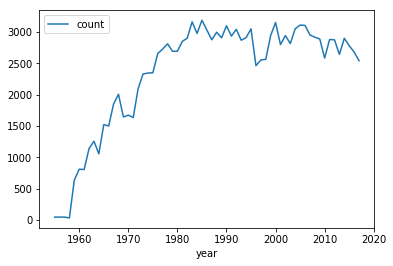

In [63]:
df_count = pd.DataFrame()
df_count['year'] = df_billboard_sp['year'].value_counts().index
df_count['count'] = df_billboard_sp['year'].value_counts().values
df_count = df_count.sort_values(by='year').reset_index()[['year', 'count']]
df_count.plot('year', 'count');

In [ ]:
# Comment : data is sufficient from c.a 1959

# Requests

## List of requests

In [68]:
df_requests = df_billboard.drop_duplicates(['Title', 'Artist'])
len(df_requests)

27066

In [261]:
df_requests.head(100)

,Title,Artist,Weeks on chart,year,Spotify_Popularity,Artist_Popularity,track_id,track_title,track_artist,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,time_signature
0,Poor Little Fool,Ricky Nelson,1.0,1955,-1,56,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool - Remastered,Ricky Nelson,0.543,0.3320,0.0,-11.573,0.0317,0.6690,0.000000,0.1340,0.795,153933.0,4.0
1,Patricia,Perez Prado And His Orchestra,NaN,1955,-1,12,205EtD8tQnHDXMkmtYiaHF,Patricia,Pérez Prado,-1.000,-1.0000,-1.0,-1.000,-1.0000,-1.0000,-1.000000,-1.0000,-1.000,-1.0,-1.0
2,Splish Splash,Bobby Darin,NaN,1955,-1,62,40fD7ct05FvQHLdQTgJelG,Splish Splash,Bobby Darin,0.645,0.9430,0.0,-1.526,0.0393,0.3850,0.000000,0.3700,0.965,131720.0,4.0
3,Hard Headed Woman,Elvis Presley With The Jordanaires,NaN,1955,-1,-1,32CVurlBxtEYQlDm3yzCLl,Hard Headed Woman,Elvis Presley,-1.000,-1.0000,-1.0,-1.000,-1.0000,-1.0000,-1.000000,-1.0000,-1.000,-1.0,-1.0
4,When,Kalin Twins,NaN,1955,-1,24,1BQOMZeYwzesvXANmRgrEp,When - Live,Kalin Twins,0.646,0.5820,6.0,-12.679,0.0297,0.1680,0.000005,0.9760,0.963,144573.0,4.0
5,Rebel-'rouser,Duane Eddy His Twangy Guitar And The Rebels,NaN,1955,-1,-1,4nAJtcmiyoL0ARY5WZY9IN,Rebel Rouser,Duane Eddy,-1.000,-1.0000,-1.0,-1.000,-1.0000,-1.0000,-1.000000,-1.0000,-1.000,-1.0,-1.0
6,Yakety Yak,The Coasters,NaN,1955,-1,53,7demHL0GXA6YmTNqw3Btz8,Yakety Yak,The Coasters,0.715,0.6690,7.0,-9.491,0.1280,0.7050,0.000732,0.0440,0.976,113040.0,4.0
7,My True Love,Jack Scott,NaN,1955,-1,32,2urRqmAFhjZKo8Z6sEGzEv,My True Love,Jack Scott,0.554,0.1890,4.0,-14.277,0.0279,0.9150,0.000014,0.1320,0.214,165293.0,3.0
8,Willie And The Hand Jive,The Johnny Otis Show,NaN,1955,-1,-1,750N0KwpG7D36cXO4gqnOc,Willie And The Hand Jive [In the Style of John...,The Karaoke Channel,0.897,0.3670,4.0,-15.751,0.0577,0.0453,0.327000,0.1430,0.957,164273.0,4.0
9,Fever,Peggy Lee,NaN,1955,-1,64,6eCsRg7OBi1zT2CEKKyoXN,Fever - Remastered,Peggy Lee,0.794,0.0715,7.0,-21.305,0.1310,0.3880,0.000000,0.1110,0.333,202507.0,4.0


## Get the tracks ids

In [197]:
df_requests['track_id'] = 'Unknown'
df_requests['track_title'] = 'Unknown'
df_requests['track_artist'] = 'Unknown'

In [198]:
len(df_requests)

27066

In [258]:
credentials = oauth2.SpotifyClientCredentials(client_id=CLIENT_ID,
                                              client_secret=CLIENT_SECRET)

token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)

In [208]:
counter = 0
df = df_requests[df_requests['track_id'] == 'Unknown']

for ind, row in df.iterrows():
    
    result = sp.search(q='track:' + row['Title'] + ' artist:' + row['Artist'], 
                            type='track', limit=1, market = 'US')
    
    # 1st attempt
    if len(result['tracks']['items']) > 0:
        df_requests['track_id'][ind] = result['tracks']['items'][0]['id']
        df_requests['track_title'][ind] = result['tracks']['items'][0]['name']
        df_requests['track_artist'][ind] = result['tracks']['items'][0]['artists'][0]['name']
    
    # 2nd attempt
    else :
        change = False
    
        artists = re.split('[\s\.,·:;\'—«»*()&]', row['Artist'])
        artist = row['Artist']
    
        if len(artists) > 2:
            artist = artists[0] + ' ' + artists[1]
            change = True
    
        title_, title = re.findall('[A-Za-z\s]+(?=[[(-])', row['Title']), row['Title']
    
        if len(title_) >= 1:
            title = title_[0]
            change = True
    
        if change :
            result = sp.search(q='track:' + title + ' artist:' + artist, 
                                type='track', limit=1, market = 'US')
    
            if len(result['tracks']['items']) > 0:
                df_requests['track_id'][ind] = result['tracks']['items'][0]['id']
                df_requests['track_title'][ind] = result['tracks']['items'][0]['name']
                df_requests['track_artist'][ind] = result['tracks']['items'][0]['artists'][0]['name']
    
    if counter%50 == 0:
        print(str(100*counter / len(df))[:5] + '%')
        time.sleep(3)
        
    if counter%5000 == 0:
        credentials = oauth2.SpotifyClientCredentials(client_id=CLIENT_ID,
                                              client_secret=CLIENT_SECRET)

        token = credentials.get_access_token()
        sp = spotipy.Spotify(auth=token)
        
    counter += 1
    

0.0%
0.274%
0.548%
0.822%
1.096%
1.371%
1.645%
1.919%
2.193%
2.468%
2.742%
3.016%
3.290%
3.565%
3.839%
4.113%
4.387%
4.662%
4.936%
5.210%
5.484%
5.759%
6.033%
6.307%
6.581%
6.856%
7.130%
retrying ...1secs
7.404%
7.678%
7.953%
8.227%
8.501%
8.775%
9.050%
9.324%
9.598%
9.872%
10.14%
10.42%
10.69%
10.96%
11.24%
11.51%
11.79%
12.06%
12.34%
12.61%
12.88%
13.16%
13.43%
13.71%
13.98%
14.26%
14.53%
14.80%
15.08%
15.35%
15.63%
15.90%
16.18%
16.45%
16.72%
17.00%
17.27%
17.55%
17.82%
18.10%
18.37%
18.64%
18.92%
19.19%
19.47%
19.74%
20.01%
20.29%
20.56%
20.84%
21.11%
21.39%
21.66%
21.93%
22.21%
22.48%
22.76%
23.03%
23.31%
23.58%
23.85%
24.13%
24.40%
24.68%
24.95%
25.23%
25.50%
25.77%
26.05%
26.32%
26.60%
26.87%
27.15%
27.42%
27.69%
27.97%
28.24%
28.52%
28.79%
29.06%
29.34%
29.61%
29.89%
30.16%
30.44%
30.71%
30.98%
31.26%
31.53%
31.81%
32.08%
32.36%
32.63%
32.90%
33.18%
33.45%
33.73%
34.00%
34.28%
34.55%
34.82%
35.10%
35.37%
35.65%
35.92%
36.20%
36.47%
36.74%
37.02%
37.29%
37.57%
37.84%
38.11%
38.3

In [272]:
df_requests.head(5)

,Title,Artist,Weeks on chart,year,Spotify_Popularity,Artist_Popularity,track_id,track_title,track_artist,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,time_signature
0,Poor Little Fool,Ricky Nelson,1.0,1955,-1,56,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool - Remastered,Ricky Nelson,0.543,0.332,0.0,-11.573,0.0317,0.6690,0.000000,0.134,0.795,153933.0,4.0
1,Patricia,Perez Prado And His Orchestra,NaN,1955,-1,12,205EtD8tQnHDXMkmtYiaHF,Patricia,Pérez Prado,0.704,0.638,1.0,-9.522,0.0457,0.0862,0.251000,0.115,0.837,140867.0,4.0
2,Splish Splash,Bobby Darin,NaN,1955,-1,62,40fD7ct05FvQHLdQTgJelG,Splish Splash,Bobby Darin,0.645,0.943,0.0,-1.526,0.0393,0.3850,0.000000,0.370,0.965,131720.0,4.0
3,Hard Headed Woman,Elvis Presley With The Jordanaires,NaN,1955,-1,-1,32CVurlBxtEYQlDm3yzCLl,Hard Headed Woman,Elvis Presley,0.610,0.699,0.0,-8.739,0.1760,0.8420,0.000002,0.501,0.859,113480.0,4.0
4,When,Kalin Twins,NaN,1955,-1,24,1BQOMZeYwzesvXANmRgrEp,When - Live,Kalin Twins,0.646,0.582,6.0,-12.679,0.0297,0.1680,0.000005,0.976,0.963,144573.0,4.0


In [273]:
print('Success rate, 1st attempt :', 18864/len(df_requests))
print('Success rate, 2nd attempt :', len(df_requests[df_requests['track_id'] != 'Unknown'])/len(df_requests))

Success rate, 1st attempt : 0.6969629793837286
Success rate, 2nd attempt : 0.7798714254045667


In [212]:
df_requests.to_csv('data/requests.csv')

In [210]:
features = sp.audio_features('5ayybTSXNwcarDtxQKqvWX')

In [224]:
features

[{'danceability': 0.897,
  'energy': 0.367,
  'key': 4,
  'loudness': -15.751,
  'mode': 1,
  'speechiness': 0.0577,
  'acousticness': 0.0453,
  'instrumentalness': 0.327,
  'liveness': 0.143,
  'valence': 0.957,
  'tempo': 100.755,
  'type': 'audio_features',
  'id': '750N0KwpG7D36cXO4gqnOc',
  'uri': 'spotify:track:750N0KwpG7D36cXO4gqnOc',
  'track_href': 'https://api.spotify.com/v1/tracks/750N0KwpG7D36cXO4gqnOc',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/750N0KwpG7D36cXO4gqnOc',
  'duration_ms': 164273,
  'time_signature': 4}]

In [229]:
df_requests['danceability'] = -1.
df_requests['energy'] = -1.
df_requests['key'] = -1.
df_requests['loudness'] = -1.
df_requests['speechiness'] = -1.
df_requests['acousticness'] = -1.
df_requests['instrumentalness'] = -1.
df_requests['liveness'] = -1.
df_requests['valence'] = -1.
df_requests['duration_ms'] = -1.
df_requests['time_signature'] = -1.

In [263]:
counter = 0
df = df_requests[df_requests['track_id'] != 'Unknown']
df = df[df['time_signature'] == -1.]

for ind, row in df.iterrows():
    
    features = sp.audio_features(row['track_id'])
        
    if len(features) > 0:
        df_requests['danceability'][ind] = features[0]['danceability']
        df_requests['energy'][ind] = features[0]['energy']
        df_requests['key'][ind] = features[0]['key']
        df_requests['loudness'][ind] = features[0]['loudness']
        df_requests['speechiness'][ind] = features[0]['speechiness']
        df_requests['acousticness'][ind] = features[0]['acousticness']
        df_requests['instrumentalness'][ind] = features[0]['instrumentalness']
        df_requests['liveness'][ind] = features[0]['liveness']
        df_requests['valence'][ind] = features[0]['valence']
        df_requests['duration_ms'][ind] = features[0]['duration_ms']
        df_requests['time_signature'][ind] = features[0]['time_signature']
    
    if counter%50 == 0:
        print(str(100*counter / len(df))[:5] + '%')
        time.sleep(3)
        
    if counter%3000 == 0:
        credentials = oauth2.SpotifyClientCredentials(client_id=CLIENT_ID,
                                              client_secret=CLIENT_SECRET)

        token = credentials.get_access_token()
        sp = spotipy.Spotify(auth=token)
        
    counter += 1

0.0%
2.228%
4.456%
6.684%
8.912%
11.14%
13.36%
15.59%
17.82%
20.05%
22.28%
24.50%
26.73%
28.96%
31.19%
33.42%
35.65%
37.87%
40.10%
42.33%
44.56%
46.79%
49.01%
51.24%
53.47%
55.70%
57.93%
60.16%
62.38%
64.61%
66.84%
69.07%
71.30%
73.52%
75.75%
77.98%
80.21%
82.44%
84.67%
86.89%
89.12%
91.35%
93.58%
95.81%
98.03%


In [265]:
df_requests.head()

,Title,Artist,Weeks on chart,year,Spotify_Popularity,Artist_Popularity,track_id,track_title,track_artist,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,time_signature
0,Poor Little Fool,Ricky Nelson,1.0,1955,-1,56,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool - Remastered,Ricky Nelson,0.543,0.332,0.0,-11.573,0.0317,0.6690,0.000000,0.134,0.795,153933.0,4.0
1,Patricia,Perez Prado And His Orchestra,NaN,1955,-1,12,205EtD8tQnHDXMkmtYiaHF,Patricia,Pérez Prado,0.704,0.638,1.0,-9.522,0.0457,0.0862,0.251000,0.115,0.837,140867.0,4.0
2,Splish Splash,Bobby Darin,NaN,1955,-1,62,40fD7ct05FvQHLdQTgJelG,Splish Splash,Bobby Darin,0.645,0.943,0.0,-1.526,0.0393,0.3850,0.000000,0.370,0.965,131720.0,4.0
3,Hard Headed Woman,Elvis Presley With The Jordanaires,NaN,1955,-1,-1,32CVurlBxtEYQlDm3yzCLl,Hard Headed Woman,Elvis Presley,0.610,0.699,0.0,-8.739,0.1760,0.8420,0.000002,0.501,0.859,113480.0,4.0
4,When,Kalin Twins,NaN,1955,-1,24,1BQOMZeYwzesvXANmRgrEp,When - Live,Kalin Twins,0.646,0.582,6.0,-12.679,0.0297,0.1680,0.000005,0.976,0.963,144573.0,4.0


In [243]:
df_requests = df_requests.drop(columns = ['date', 'Rank'])

In [264]:
df_requests.to_csv('data/dataset.csv')

## Check the quality of the dataset

In [266]:
df_merged = pd.merge(df_billboard, df_requests, on = ['Title', 'Artist'])

In [267]:
df_merged_sp = (df_merged[df_merged['time_signature'] != -1.])

In [268]:
len(df_merged_sp)

245092

In [269]:
len(df_billboard)

300600

In [270]:
df_merged_sp.head()

,date,Rank,Title,Artist,Weeks on chart_x,year_x,Spotify_Popularity_x,Artist_Popularity_x,Weeks on chart_y,year_y,...,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,time_signature
0,1955-01-01,1,Poor Little Fool,Ricky Nelson,1.0,1955,-1,56,1.0,1955,...,0.332,0.0,-11.573,0.0317,0.669,0.0,0.134,0.795,153933.0,4.0
1,1955-01-08,1,Poor Little Fool,Ricky Nelson,1.0,1955,-1,56,1.0,1955,...,0.332,0.0,-11.573,0.0317,0.669,0.0,0.134,0.795,153933.0,4.0
2,1955-01-15,1,Poor Little Fool,Ricky Nelson,1.0,1955,-1,56,1.0,1955,...,0.332,0.0,-11.573,0.0317,0.669,0.0,0.134,0.795,153933.0,4.0
3,1955-01-22,1,Poor Little Fool,Ricky Nelson,1.0,1955,-1,56,1.0,1955,...,0.332,0.0,-11.573,0.0317,0.669,0.0,0.134,0.795,153933.0,4.0
4,1955-02-01,1,Poor Little Fool,Ricky Nelson,1.0,1955,-1,56,1.0,1955,...,0.332,0.0,-11.573,0.0317,0.669,0.0,0.134,0.795,153933.0,4.0


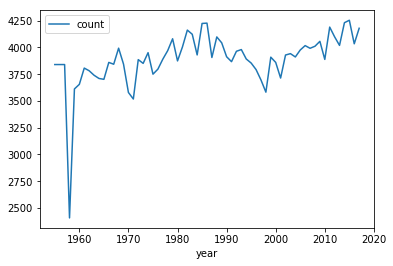

In [271]:
df_count = pd.DataFrame()
df_count['year'] = df_merged_sp['year_x'].value_counts().index
df_count['count'] = df_merged_sp['year_x'].value_counts().values
df_count = df_count.sort_values(by='year').reset_index()[['year', 'count']]
df_count.plot('year', 'count');